In [1]:
import pandas as pd

In [6]:
df_breakpoint = pd.read_csv('breakpoint.csv')
df_breakpoint = df_breakpoint.drop(columns='Unnamed: 0')

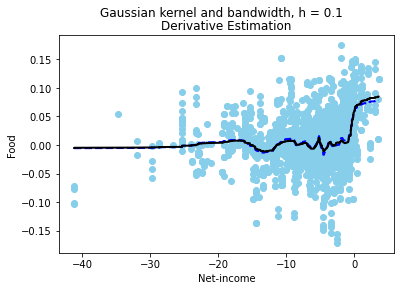

In [7]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Load data
# 读取数据
x = np.array(df_breakpoint['csbd'])
y = np.array(df_breakpoint['return'])
indices = np.argsort(x)
x = x[indices]
y = y[indices]
#x_i = (i-0.5)/n
xs = np.array([(i-0.5)/len(x) for i in range(1,len(x)+1)])

# Bandwidth
h = 0.1

# Local polynomial regression
lowess = sm.nonparametric.lowess
mh = lowess(y, xs, frac=h, it=0)
md = lowess(y, xs, frac=h, it=1, delta=0.01)

# Plot
plt.plot(x, y, 'o', color='skyblue')
plt.plot(x, mh[:, 1], color='blue', linestyle='dashed', linewidth=2)
plt.plot(x, md[:, 1], color='black', linewidth=2)
plt.xlabel("Net-income")
plt.ylabel("Food")
plt.title("Derivative Estimation")
plt.suptitle(f"Gaussian kernel and bandwidth, h = {h}")
plt.show()


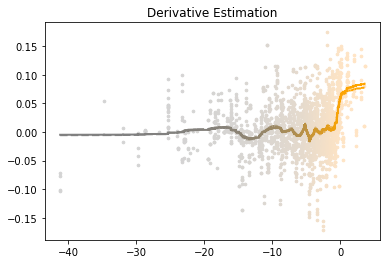

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


def gradient_color(start_color, end_color, n):
    start = np.array(mcolors.to_rgba(start_color))
    end = np.array(mcolors.to_rgba(end_color))
    return [start + (end - start) * i / (n - 1) for i in range(n)]


scatter_colors = gradient_color('lightgray', 'bisque', len(x))


plot_colors_gmqua = gradient_color('gray', 'orange', len(x) - 1)
plot_colors_gmfde = gradient_color('gray', 'orange', len(x) - 1)

plt.figure()


for i in range(len(x)):
    plt.scatter(x[i], y[i], color=scatter_colors[i], s=7)


for i in range(len(x) - 1):
    plt.plot(x[i:i+2], mh[:, 1][i:i+2],linestyle='dashed', color=plot_colors_gmqua[i], linewidth=2)


for i in range(len(x) - 1):
    plt.plot(x[i:i+2], md[:, 1][i:i+2], color=plot_colors_gmfde[i], linewidth=2)

plt.title("Derivative Estimation")

plt.savefig('Derivative Estimation.png', transparent=True)
plt.show()


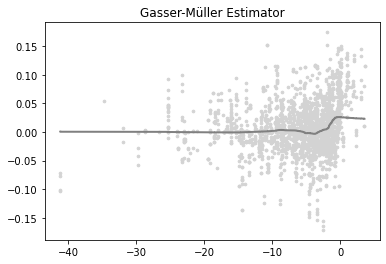

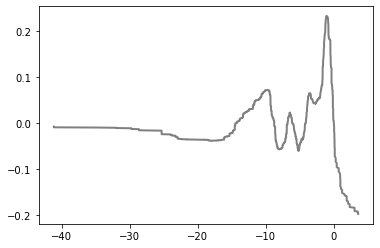

In [9]:
import numpy as np
import matplotlib.pyplot as plt

def kernel(time, x, h, fun):
    def uni(time, avg_t, h):
        s = 0.5 * (avg_t[1:] - avg_t[:-1]) / h
        s = s * (np.abs((avg_t[1:] - time) / h) <= 1)
        return s

    def qua(time, avg_t, h):
        r = (time - avg_t) / h
        s = ((3 * r[:-1] - r[:-1]**3) - (3 * r[1:] - r[1:]**3)) / 4
        s = s * (np.abs((avg_t[1:] - time) / h) <= 1)
        return s

    def fde(time, avg_t, h):
        r = (time - avg_t) / h
        s = 15 * ((r[:-1]**4 - 2 * r[:-1]**2) - (r[1:]**4 - 2 * r[1:]**2)) / (16 * h)
        s = s * (np.abs((avg_t[1:] - time) / h) <= 1)
        return s

    def sde(time, avg_t, h):
        r = (time - avg_t) / h
        s = 105 * ((2 * r[:-1]**3 - r[:-1]**5 - r[:-1]) - (2 * r[1:]**3 - r[1:]**5 - r[1:])) / (16 * h**2)
        s = s * (np.abs((avg_t[1:] - time) / h) <= 1)
        return s

    if h <= 0:
        raise ValueError("Bandwidth h must be a positive value!")
    if len(x) != len(time):
        raise ValueError("Number of sample intervals and number of data should be the same!")

    avg_t = np.zeros(len(time) + 1)
    avg_t[1:-1] = (time[:-1] + time[1:]) / 2
    avg_t[0] = time[0]
    avg_t[-1] = time[-1]

    smooth_d = np.zeros(len(time))

    weight_functions = {'uni': uni, 'qua': qua, 'fde': fde, 'sde': sde}
    weight_func = weight_functions.get(fun, qua)

    for i, t in enumerate(time):
        S = weight_func(t, avg_t, h)
        smooth_d[i] = np.dot(S, x)

    return smooth_d

# Main computation

# 创建一个带有斜率突变的数据集（x和y都不是整数）
x = np.array(df_breakpoint['csbd'])
y = np.array(df_breakpoint['return'])
indices = np.argsort(x)
x = x[indices]
y = y[indices]
#x_i = (i-0.5)/n
xs = np.array([(i-0.5)/len(x) for i in range(1,len(x)+1)])

h = 0.15



GMqua = kernel(xs, y, h, "qua")
GMfde = kernel(xs, y, h, "fde")



# Plotting
plt.figure()
plt.title("Gasser-Müller Estimator")
plt.scatter(x, y, color='lightgray', s=7)
plt.plot(x, GMqua, color='gray', linewidth=2)
plt.figure()
plt.plot(x, GMfde, color='gray', linewidth=2)
plt.show()


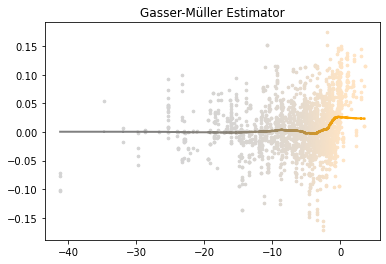

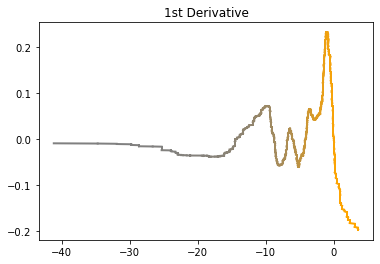

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# 创建颜色渐变函数
def gradient_color(start_color, end_color, n):
    start = np.array(mcolors.to_rgba(start_color))
    end = np.array(mcolors.to_rgba(end_color))
    return [start + (end - start) * i / (n - 1) for i in range(n)]

# scatter 的颜色渐变
scatter_colors = gradient_color('lightgray', 'bisque', len(x))

# plot 的颜色渐变
plot_colors_gmqua = gradient_color('gray', 'orange', len(x) - 1)
plot_colors_gmfde = gradient_color('gray', 'orange', len(x) - 1)

plt.figure()
plt.title("Gasser-Müller Estimator")

# 绘制彩色的散点图
for i in range(len(x)):
    plt.scatter(x[i], y[i], color=scatter_colors[i], s=7)

# 绘制彩色的线条 (GMqua)
for i in range(len(x) - 1):
    plt.plot(x[i:i+2], GMqua[i:i+2], color=plot_colors_gmqua[i], linewidth=2)
plt.savefig('GM Estimator1.png', transparent=True)
plt.figure()

# 绘制彩色的线条 (GMfde)
for i in range(len(x) - 1):
    plt.plot(x[i:i+2], GMfde[i:i+2], color=plot_colors_gmfde[i], linewidth=2)

plt.title("1st Derivative")

plt.savefig('GM Estimator2.png', transparent=True)
plt.show()


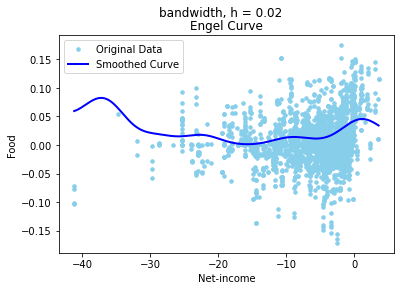

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# 读取数据
x = np.array(df_breakpoint['csbd'])
y = np.array(df_breakpoint['return'])
indices = np.argsort(x)
x = x[indices]
y = y[indices]
#x_i = (i-0.5)/n
xs = np.array([(i-0.5)/len(x) for i in range(1,len(x)+1)])

# 使用高斯核平滑
kde = gaussian_kde(x, bw_method=h)
x_grid = np.linspace(x.min(), x.max(), 500)
xs_grid = np.linspace(xs.min(), xs.max(), 500)
y_smooth = kde.evaluate(xs_grid)
h = 0.02  # 带宽

# 绘图
plt.figure()
plt.plot(x, y, 'o', color='skyblue', markersize=3.5, label='Original Data')
plt.plot(x_grid, y_smooth, color='blue', linewidth=2, label='Smoothed Curve')
plt.xlabel("Net-income")
plt.ylabel("Food")
plt.title("Engel Curve")
plt.suptitle(f"bandwidth, h = {h}")
plt.legend()
plt.show()


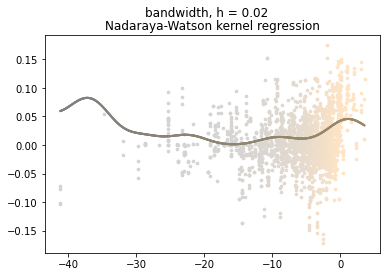

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# 创建颜色渐变函数
def gradient_color(start_color, end_color, n):
    start = np.array(mcolors.to_rgba(start_color))
    end = np.array(mcolors.to_rgba(end_color))
    return [start + (end - start) * i / (n - 1) for i in range(n)]

# scatter 的颜色渐变
scatter_colors = gradient_color('lightgray', 'bisque', len(x))

# plot 的颜色渐变
plot_colors_gmqua = gradient_color('gray', 'orange', len(x) - 1)
plot_colors_gmfde = gradient_color('gray', 'orange', len(x) - 1)

plt.figure()

plt.title("Nadaraya-Watson kernel regression")
plt.suptitle(f"bandwidth, h = {h}")

# 绘制彩色的散点图
for i in range(len(x)):
    plt.scatter(x[i], y[i], color=scatter_colors[i], s=7)

# 绘制彩色的线条 (GMqua)
for i in range(len(x) - 1):
    plt.plot(x_grid[i:i+2], y_smooth[i:i+2], color=plot_colors_gmqua[i], linewidth=2)

plt.savefig('Nadaraya-Watson kernel regression.png',transparent = True)

